In [5]:
import pandas as pd
import json
import numpy as np
import os

scenario = 'CPPS_Diagonal'

radar_files = [
    "CPPS_Diagonal/Cable_Robot/radar_data_20250219_174602.txt",
    "CPPS_Diagonal/Robot_1/radar_logs/radar_data_CPPS_diagonal_20250219_174937.txt",
    "CPPS_Diagonal/Robot_2/radar_logs/radar_data_CPPS_diagonal_20250219_174939.txt",
]

vicon_files = [
    "CPPS_Diagonal/Vicon/CPPS_diagonal_20250219_174909_v3.txt"
] #"vicon_data_sample_multi.txt"


output_filtered_radar_filename = "output/"+ scenario +"/filtered_radar_"
output_vicon_data_filename = "output/"+ scenario +"/vicon_resample_" + scenario + ".csv"
output_sync_radar_nodes_filename = "output/"+ scenario +"/sync_radar_nodes_" + scenario + ".csv"
output_final_filename = "output/"+ scenario +"/" + scenario + ".csv"


### Radar Data Reading ###

In [ ]:
# Read radar data and create separate DataFrames for each node
def read_radar_data(file_paths):
    radar_dfs = {}  # Dictionary to store DataFrames for each node

    for file in file_paths:
        # Extract Node ID from file name and ensure proper formatting
        try:
            node_name = file.split("/")[1]  # Get the second part of the path as Node Name
            node_id = node_name  # Use this directly as our Node ID
        except IndexError:
            raise ValueError(f"Invalid file path format: {file}. Expected at least two '/' characters.")
        radar_data = []
        try:
            with open(file, 'r') as f:
                for line in f:
                    try:
                        radar_data.append(json.loads(line))  # Parse JSON line by line
                    except json.JSONDecodeError:
                        print(f"Skipping invalid JSON line in file {file}: {line.strip()}")
        except FileNotFoundError:
            raise FileNotFoundError(f"File not found: {file}")

        if not radar_data:
            print(f"No valid data found in file: {file}")
            continue  # Skip this file if no data

        # Create a DataFrame for this node
        df = pd.DataFrame(radar_data)
        df.rename(columns={'timestamp': f'{node_id}_timestamp'}, inplace=True)  # Rename timestamp column
        df['Node_ID'] = node_id  # Add properly formatted Node ID column

        radar_dfs[node_id] = df  # Store the DataFrame in the dictionary

    if not radar_dfs:
        raise ValueError("No valid radar data files were processed.")
    
    return radar_dfs

# def read_radar_data_(file_paths):
#     radar_dataframes = []
#     for file in file_paths:
#         with open(f"measurements/radar_data/{file}", 'r') as f:
#             radar_data = [json.loads(line) for line in f]
#             df = pd.DataFrame(radar_data)
#             df.rename(columns={'timestamp': 'timestamp_radar'}, inplace=True)
#             radar_dataframes.append(df)
#     radar_df = pd.concat(radar_dataframes, ignore_index=True)
#     return radar_df

# Step 1: Read radar data and create separate DataFrames for each node

radar_dfs = read_radar_data(radar_files)

# Print separate DataFrames for each node
for node_id in ['Cable_Robot', 'Robot_1', 'Robot_2']:
    if node_id in radar_dfs:
        print(f"{node_id.capitalize()} DataFrame:")
        print(radar_dfs[node_id].head())
    else:
        print(f"{node_id.capitalize()} data not found.")

radar_dfs

In [ ]:
radar_dfs['Cable_Robot'].columns

### Vicon Data Reading ###

In [ ]:
# Step 2: Read and decode Vicon data files


def read_vicon_data(file_paths):
    vicon_dataframes = []
    
    for file in file_paths:
        with open(file, 'r') as f:
            rows = []
            for line in f:
                line = line.strip()  # Remove whitespace or newline characters
                if line:  # Skip empty lines
                    try:
                        vicon_dict = eval(line)  # Evaluate the line into a dictionary
                        object_count = 1  # Initialize object counter
                        row_data = {}
                        for key, value in vicon_dict.items():
                            # Robust check to skip rows where all values are zero
                            if isinstance(value, dict) and all(v == 0 for v in value.values()):
                                continue  # Skip this entry
                            # Extract object name from key
                            object_name = key.split("/")[1]
                            # Rename keys with object_name prefix and handle multiple objects
                            renamed_value = {
                                f"{object_name}_{k}": v
                                for k, v in value.items()
                                if k not in ['frame_number', 'total_latency', 'quality']
                            }
                            # Add vicon_timestamp for the first object
                            if object_count == 1:
                                renamed_value['vicon_timestamp'] = renamed_value.pop(f"{object_name}_system_time") / 1e9
                            else:
                                renamed_value[f'object_name_{object_count}'] = object_name
                                renamed_value[f"object_name_{object_count}_timestamp"] = renamed_value.pop(
                                    f"{object_name}_system_time"
                                ) / 1e9
                            # Add object_name for the first object
                            if object_count == 1:
                                renamed_value['object_name_1'] = object_name
                            row_data.update(renamed_value)
                            object_count += 1
                        # Add row if it's not empty
                        if row_data:  # Ensure that the row contains valid data
                            rows.append(row_data)
                    except SyntaxError as e:
                        print(f"Error parsing line: {line}\n{e}")
            
            # Create a DataFrame for the parsed rows
            if rows:
                df = pd.DataFrame(rows)
                vicon_dataframes.append(df)
    
    # Combine all DataFrames into one
    vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()

    # Reorder columns: vicon_timestamp first, followed by object_name columns, then the rest
    if not vicon_df.empty:
        columns = sorted(
            [col for col in vicon_df.columns if 'vicon_timestamp' in col] +
            [col for col in vicon_df.columns if col.startswith('object_name')],
            key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0
        )
        remaining_columns = [col for col in vicon_df.columns if col not in columns]
        vicon_df = vicon_df[columns + remaining_columns]
    
    return vicon_df


vicon_df = read_vicon_data(vicon_files)
vicon_df



In [ ]:
vicon_df.columns
# Save vicon data
#vicon_df.to_csv('output/vicon_data_test.csv', index=False)

In [ ]:
# Function to read and process Vicon data
# Function to manually decode and process Vicon data old version
# def read_vicon_data(file_paths):
#     vicon_dataframes = []
#     for file in file_paths:
#         with open(f"measurements/vicon_data/{file}", 'r') as f:
#             rows = []
#             for line in f:
#                 line = line.strip()  # Remove whitespace or newline characters
#                 if line:  # Skip empty lines
#                     # Manually parse the line
#                     try:
#                         vicon_dict = eval(line)  # Evaluate the line into a dictionary
#                         for key, value in vicon_dict.items():
#                             # Check if all values in the entry are zero
#                             if all(val == 0 for val in value.values()):
#                                 continue  # Skip this entry
#                             # Extract object name from key
#                             object_name = key.split("/")[1]
#                             # Add object name and system time (converted to seconds) to the data
#                             value['object_name'] = object_name
#                             value['system_time'] = value['system_time'] / 1e9  # Convert to seconds
#                             rows.append(value)
#                     except SyntaxError as e:
#                         print(f"Error parsing line: {line}\n{e}")
#             # Create a DataFrame for the parsed rows
#             if rows:
#                 df = pd.DataFrame(rows)
#                 vicon_dataframes.append(df)
#     # Combine all dataframes into one
#     vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()
#     return vicon_df

# def read_vicon_data(file_paths):
#     vicon_dataframes = []
    
#     for file in file_paths:
#         with open(file, 'r') as f:
#             rows = []
#             for line in f:
#                 line = line.strip()  # Remove whitespace or newline characters
#                 if line:  # Skip empty lines
#                     try:
#                         vicon_dict = eval(line)  # Evaluate the line into a dictionary
#                         for key, value in vicon_dict.items():
#                             # Check if all values in the entry are zero
#                             if all(val == 0 for val in value.values()):
#                                 continue  # Skip this entry
#                             # Extract object name from key
#                             object_name = key.split("/")[1]
#                             # Rename keys with object_name prefix
#                             renamed_value = {f"{object_name}_{k}": v for k, v in value.items() if k not in ['frame_number', 'total_latency', 'quality']}
#                             renamed_value['object_name'] = object_name
#                             renamed_value['vicon_timestamp'] = renamed_value.pop(f"{object_name}_system_time") / 1e9  # Rename system_time for the first object
#                             rows.append(renamed_value)
#                     except SyntaxError as e:
#                         print(f"Error parsing line: {line}\n{e}")
            
#             # Create a DataFrame for the parsed rows
#             if rows:
#                 df = pd.DataFrame(rows)
#                 vicon_dataframes.append(df)
    
#     # Combine all DataFrames into one
#     vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()
#     return vicon_df

### Resampling Vicon Data ###

In [ ]:
def resample_vicon_old(df_vicon, resample_interval='40ms'):
    if df_vicon.empty:
        return df_vicon  # Return empty DataFrame if input is empty
    
    # Convert `vicon_timestamp` to datetime for resampling
    df_vicon['time_resample'] = pd.to_datetime(df_vicon['vicon_timestamp'], unit='s')
    
    # Handle non-unique indices by aggregating duplicate timestamps
    df_vicon = df_vicon.groupby('time_resample').mean().reset_index()
    
    # Set datetime as index for resampling
    df_vicon = df_vicon.set_index('time_resample').sort_index()
    
    # Resample and forward-fill missing values
    df_vicon_resampled = df_vicon.resample(resample_interval).ffill()
    
    # Drop rows with NaN values after resampling
    df_vicon_resampled = df_vicon_resampled.dropna().reset_index()
    df_vicon_resampled = df_vicon_resampled.drop('time_resample', axis=1)
    
    # Rename resampled timestamp to `vicon_timestamp`
    #df_vicon_resampled.rename(columns={'time_resample': 'vicon_timestamp'}, inplace=True)
    
    # Ensure `vicon_timestamp` is in seconds format
    #df_vicon_resampled['vicon_timestamp'] = df_vicon_resampled['vicon_timestamp'].astype(int) / 1e9
    
    return df_vicon_resampled

def resample_vicon(df_vicon, resample_interval='40ms'):
    if df_vicon.empty:
        return df_vicon  # Return empty DataFrame if input is empty
    
    # Convert `vicon_timestamp` to datetime for resampling
    df_vicon['time_resample'] = pd.to_datetime(df_vicon['vicon_timestamp'], unit='s')
    
    # Separate non-numerical columns
    non_numerical_cols = [col for col in df_vicon.columns if df_vicon[col].dtype == 'object']
    numerical_cols = [col for col in df_vicon.columns if col not in non_numerical_cols + ['time_resample']]

    # Aggregate non-numerical columns by taking the first value
    df_vicon_non_num = df_vicon.groupby('time_resample')[non_numerical_cols].first()
    
    # Aggregate numerical columns using forward-fill
    df_vicon_num = df_vicon.groupby('time_resample')[numerical_cols].mean()
    
    # Combine numerical and non-numerical data
    df_vicon_combined = pd.concat([df_vicon_num, df_vicon_non_num], axis=1).reset_index()
    
    # Resample based on time interval and forward-fill missing values
    df_vicon_combined = df_vicon_combined.set_index('time_resample').sort_index()
    df_vicon_resampled = df_vicon_combined.resample(resample_interval).ffill().dropna().reset_index()
    df_vicon_resampled = df_vicon_resampled.drop('time_resample', axis=1)

    # Rename resampled timestamp back to `vicon_timestamp`
    #df_vicon_resampled.rename(columns={'time_resample': 'vicon_timestamp'}, inplace=True)
    
    # Ensure `vicon_timestamp` is in seconds format
    #df_vicon_resampled['vicon_timestamp'] = df_vicon_resampled['vicon_timestamp'].astype(float)
    
    return df_vicon_resampled


resampled_vicon_df = resample_vicon(vicon_df, resample_interval='25ms')
resampled_vicon_df

In [ ]:
# Save resample vicon data
resampled_vicon_df.to_csv(output_vicon_data_filename, index=False)

### Filter the Radar Data ###

In [ ]:
# Step 3: Filter radar data based on Vicon timestamps
# Filter radar data based on Vicon timestamps
def filter_radar_by_vicon_time(radar_df, vicon_df):
    start_time = resampled_vicon_df['vicon_timestamp'].min()
    end_time = resampled_vicon_df['vicon_timestamp'].max()
    filtered_radar_df = radar_df[
        (radar_df[f'{radar_df["Node_ID"].iloc[0]}_timestamp'] >= start_time) &
        (radar_df[f'{radar_df["Node_ID"].iloc[0]}_timestamp'] <= end_time)
    ]
    print("num of rows: ", len(filtered_radar_df))
    return filtered_radar_df

filtered_radar_dfs = {}  # Create a new dictionary to store filtered data

for node_id in radar_dfs:
    print(node_id)
    filtered_radar_dfs[node_id] = filter_radar_by_vicon_time(radar_dfs[node_id], resampled_vicon_df)
    filtered_radar_dfs[node_id] = filtered_radar_dfs[node_id].reset_index(drop=True)

In [ ]:
# Print and store to csv separate DataFrames for each node
for node_id in ['Cable_Robot', 'Robot_1', 'Robot_2']:
    if node_id in filtered_radar_dfs:
        print(f"{node_id.capitalize()} DataFrame:")
        print(filtered_radar_dfs[node_id].head())
        print("Saving Filtered Radar Data ", node_id)
        filtered_radar_dfs[node_id].to_csv(output_filtered_radar_filename + node_id + '_' + scenario + '.csv', index=False, na_rep='NaN')
    else:
        print(f"{node_id.capitalize()} data not found.")

filtered_radar_dfs['Cable_Robot']

In [ ]:
print(filtered_radar_dfs['Cable_Robot']['Cable_Robot_timestamp'].dtype)  # Should be float64
print(filtered_radar_dfs['Robot_1']['Robot_1_timestamp'].dtype)  # Should be float64
print(filtered_radar_dfs['Robot_2']['Robot_2_timestamp'].dtype)  # Should be float64

### Synchronize Radar Data per Node ###

In [ ]:
# # Step 4: Synchronize radar data across nodes WITHOUT INTERPOLATION

# def synchronize_radar_nodes(radar_dfs):
#     node_2_df = radar_dfs['node_2']
#     synchronized_data = []

#     for _, node_2_row in node_2_df.iterrows():
#         sync_row = {}  # Initialize a new dictionary to store synchronized data

#         # Add Node 1 data
#         if 'node_1' in radar_dfs:
#             node_1_df = radar_dfs['node_1']
#             closest_idx = (np.abs(node_1_df['node_1_timestamp'] - node_2_row['node_2_timestamp'])).idxmin()
#             node_1_data = node_1_df.loc[closest_idx].drop('Node_ID').to_dict()  # Drop Node_ID column
#             for key, value in node_1_data.items():
#                 # Add timestamp column without prefix
#                 if key == 'node_1_timestamp':
#                     sync_row[key] = value
#                 else:
#                     sync_row[f'node_1_{key}'] = value

#         # Add Node 2 data
#         node_2_data = node_2_row.drop('Node_ID').to_dict()  # Drop Node_ID column
#         for key, value in node_2_data.items():
#             # Add timestamp column without prefix
#             if key == 'node_2_timestamp':
#                 sync_row[key] = value
#             else:
#                 sync_row[f'node_2_{key}'] = value

#         # Add Node 3 data
#         if 'node_3' in radar_dfs:
#             node_3_df = radar_dfs['node_3']
#             closest_idx = (np.abs(node_3_df['node_3_timestamp'] - node_2_row['node_2_timestamp'])).idxmin()
#             node_3_data = node_3_df.loc[closest_idx].drop('Node_ID').to_dict()  # Drop Node_ID column
#             for key, value in node_3_data.items():
#                 # Add timestamp column without prefix
#                 if key == 'node_3_timestamp':
#                     sync_row[key] = value
#                 else:
#                     sync_row[f'node_3_{key}'] = value

#         synchronized_data.append(sync_row)

#         # Convert synchronized data into a DataFrame
#         synchronized_df = pd.DataFrame(synchronized_data)

#         # Reorder columns to ensure Node 1 data comes first, followed by Node 2 and Node 3
#         column_order = (
#             [col for col in synchronized_df.columns if col.startswith('node_1_') or col == 'node_1_timestamp'] +
#             [col for col in synchronized_df.columns if col.startswith('node_2_') or col == 'node_2_timestamp'] +
#             [col for col in synchronized_df.columns if col.startswith('node_3_') or col == 'node_3_timestamp']
#         )
#         synchronized_df = synchronized_df[column_order]
#     return synchronized_df


# synchronized_radar_df = synchronize_radar_nodes(filtered_radar_dfs)
# synchronized_radar_df

In [ ]:
# Step 4: Synchronize radar data across nodes WITH INTERPOLATION
import numpy as np
import pandas as pd

def detect_and_fill_gaps_v2(df, timestamp_col, sampling_interval, fields_to_interpolate, interpolation_enabled=True):
    """
    Detect and fill gaps in radar data by inserting missing timestamps and handling gaps.
    Args:
        df (pd.DataFrame): Input DataFrame containing radar data.
        timestamp_col (str): Column name for the timestamp (in UNIX seconds).
        sampling_interval (float): Expected interval in seconds (e.g., 0.05 for 50ms).
        fields_to_interpolate (list): List of radar data fields to handle during gaps.
        interpolation_enabled (bool): Whether to perform interpolation for missing data.

    Returns:
        pd.DataFrame: DataFrame with gaps filled and data interpolated (if enabled).
    """
    # Ensure DataFrame is sorted by timestamp
    df = df.sort_values(timestamp_col).reset_index(drop=True)

    # Detect gaps where the timestamp difference exceeds 5 seconds
    df['time_diff'] = df[timestamp_col].diff()

    # Generate a complete timestamp range by filling gaps
    complete_timestamps = []
    for i in range(len(df) - 1):
        t_now, t_next = df.loc[i, timestamp_col], df.loc[i + 1, timestamp_col]
        complete_timestamps.append(t_now)

        # Fill gaps by interpolating timestamps based on sampling_interval
        gap_length = t_next - t_now
        if gap_length > 5:  # If gap > 5 seconds
            num_interpolated_points = int(gap_length / sampling_interval)
            print(f"t_now: {t_now}, t_next: {t_next}, num points: {num_interpolated_points}")
            missing_timestamps = np.linspace(t_now + sampling_interval, t_next - sampling_interval, num_interpolated_points)
            complete_timestamps.extend(missing_timestamps)
    complete_timestamps.append(df[timestamp_col].iloc[-1])

    # for i in range(len(df) - 1):
    #     t_now, t_next = df.loc[i, timestamp_col], df.loc[i + 1, timestamp_col]
    #     complete_timestamps.append(t_now)

    #     # Fill gaps by interpolating timestamps based on sampling_interval
    #     if t_next - t_now > 5:  # If gap > 5 seconds
    #         missing_timestamps = np.arange(t_now + sampling_interval, t_next, sampling_interval)
    #         complete_timestamps.extend(missing_timestamps)
    # complete_timestamps.append(df[timestamp_col].iloc[-1])

    # Create a DataFrame with all timestamps
    complete_df = pd.DataFrame({timestamp_col: complete_timestamps})
    
    # Merge the original data into the complete timestamp range
    df = pd.merge(complete_df, df, on=timestamp_col, how='left')

    # Fill gaps with NaN for radar fields
    if interpolation_enabled:
        for field in fields_to_interpolate:
            if field in df.columns:
                df[field] = df[field].interpolate(method='linear', limit_direction='both')

    # Remove temporary columns and return
    df.drop(columns=['time_diff'], errors='ignore', inplace=True)
    return df
def synchronize_radar_nodes_v2(radar_dfs, sampling_interval=0.05, interpolation_enabled=False):
    """
    Synchronize radar data across multiple nodes dynamically based on available nodes.
    
    Args:
        radar_dfs (dict): Dictionary of DataFrames for each radar node.
                          Keys are node names (e.g., 'Cable_Robot', 'Robot_1').
                          Values are corresponding pandas DataFrames.
                          
        sampling_interval (float): Sampling interval in seconds (e.g., 0.05 for 50ms).
        
        interpolation_enabled (bool): Whether to enable interpolation for missing values.

    Returns:
        pd.DataFrame: Synchronized radar data across nodes.
                      Includes combined information from all nodes aligned by time.
    """
    # Select a reference node for synchronization (first key in the dictionary)
    reference_node = list(radar_dfs.keys())[2]
    ref_df = radar_dfs[reference_node]
    
    # Ensure gaps are filled and timestamps are consistent in the reference node
    ref_df = detect_and_fill_gaps_v2(
        ref_df,
        timestamp_col=f'{reference_node}_timestamp',
        sampling_interval=sampling_interval,
        fields_to_interpolate=[],
        interpolation_enabled=False
    )
    
    # Initialize an empty list to store synchronized rows
    synchronized_data = []
    
    # Iterate through each row in the reference DataFrame
    for _, ref_row in ref_df.iterrows():
        sync_row = {}  # A single synchronized row
        
        # Add reference node's data to the sync row
        ref_data = ref_row.to_dict()
        for key, value in ref_data.items():
            if key == f'{reference_node}_timestamp':
                sync_row[key] = value
            else:
                sync_row[f'{reference_node}_{key}'] = value
        
        # Align other nodes with the reference timestamp
        ref_timestamp = ref_row[f'{reference_node}_timestamp']
        
        for node_name, df in radar_dfs.items():
            if node_name == reference_node:
                continue  # Skip the reference node

            # Ensure gaps are filled and timestamps are consistent for this node
            df = detect_and_fill_gaps_v2(
                df,
                timestamp_col=f'{node_name}_timestamp',
                sampling_interval=sampling_interval,
                fields_to_interpolate=[],
                interpolation_enabled=interpolation_enabled
            )
            
            # Find the closest timestamp in this node's DataFrame to the current reference timestamp
            closest_idx = (np.abs(df[f'{node_name}_timestamp'] - ref_timestamp)).idxmin()
            closest_data = df.loc[closest_idx].drop('Node_ID', errors='ignore').to_dict()
            
            # Add this node's data to the sync row with appropriate prefixing
            for key, value in closest_data.items():
                if key == f'{node_name}_timestamp':
                    sync_row[key] = value  # Keep original column name for timestamps
                else:
                    sync_row[f'{node_name}_{key}'] = value
        
        synchronized_data.append(sync_row)  # Append this row to our results
    
    # Convert synchronized rows into a DataFrame
    synchronized_df = pd.DataFrame(synchronized_data)
    
    return synchronized_df


synchronized_radar_df = synchronize_radar_nodes_v2(filtered_radar_dfs, sampling_interval=0.05, interpolation_enabled=False)
synchronized_radar_df

In [ ]:
# Save synchronized radar data
synchronized_radar_df.to_csv(output_sync_radar_nodes_filename, index=False, na_rep='NaN')

In [ ]:
# # Step 5: Synchronize radar and Vicon data
# # Find the closest Vicon timestamp for each radar timestamp
# # Function to filter radar data based on Vicon timestamps
# def filter_radar_by_vicon_time(radar_df, vicon_df):
#     start_time = vicon_df['system_time'].min()
#     end_time = vicon_df['system_time'].max()
#     filtered_radar_df = radar_df[(radar_df['timestamp_radar'] >= start_time) & 
#                                  (radar_df['timestamp_radar'] <= end_time)]
#     return filtered_radar_df



# filtered_radar_df = filter_radar_by_vicon_time(radar_df, vicon_df)
# filtered_radar_df

### Synchronization of Radar and Vicon Data ###

In [ ]:
import pandas as pd

 # Step 5: Synchronize radar and Vicon data

# Function to synchronize radar and Vicon data
# def synchronize_data(radar_df, vicon_df):
#     synchronized_data = []
#     for _, radar_row in radar_df.iterrows():
#         closest_vicon_idx = (np.abs(vicon_df['system_time'] - radar_row['timestamp_radar'])).idxmin()
#         closest_vicon_row = vicon_df.loc[closest_vicon_idx]
#         combined_row = {**radar_row.to_dict(), **closest_vicon_row.to_dict()}
#         synchronized_data.append(combined_row)
#     synchronized_df = pd.DataFrame(synchronized_data)
#     return synchronized_df


def synchronize_radar_vicon(synchronized_radar_df, vicon_df, radar_reference_node=None):
    """
    Synchronize radar data with Vicon data dynamically based on available nodes.
    
    Args:
        synchronized_radar_df (pd.DataFrame): DataFrame containing synchronized radar data across multiple nodes.
                                              Should include timestamp columns for each node.
                                              
        vicon_df (pd.DataFrame): DataFrame containing Vicon motion capture data.
                                 Must include a 'vicon_timestamp' column for alignment.
        
        radar_reference_node (str): The node name to use as the reference for synchronization with Vicon timestamps.
                                    If None, the first available node in `synchronized_radar_df` will be used.

    Returns:
        pd.DataFrame: DataFrame containing synchronized radar and Vicon data combined into a single structure.
                      Includes prefixed columns from both sources for clarity.
    """
    # Ensure 'vicon_timestamp' exists in the Vicon DataFrame
    if 'vicon_timestamp' not in vicon_df.columns:
        raise KeyError("The column 'vicon_timestamp' is missing from the Vicon DataFrame.")

    # Determine which radar node's timestamp to use as reference
    if not radar_reference_node:
        # Dynamically select the first available timestamp column in `synchronized_radar_df`
        radar_timestamps = [col for col in synchronized_radar_df.columns if col.endswith('_timestamp')]
        if not radar_timestamps:
            raise ValueError("No timestamp columns found in the synchronized Radar DataFrame.")
        # Extract the reference node name by removing '_timestamp'
        radar_reference_node = radar_timestamps[0].replace('_timestamp', '')

    reference_col = f"{radar_reference_node}_timestamp"

    # Ensure that the chosen reference column exists
    if reference_col not in synchronized_radar_df.columns:
        raise KeyError(f"The reference column '{reference_col}' is missing from the Radar DataFrame.")

    # Initialize an empty list to store combined rows
    synchronized_data = []

    # Iterate through each row of the Radar DataFrame using the reference node's timestamps
    for _, radar_row in synchronized_radar_df.iterrows():
        ref_timestamp = radar_row[reference_col]

        # Find closest row in Vicon based on timestamp difference
        closest_vicon_idx = (np.abs(vicon_df['vicon_timestamp'] - ref_timestamp)).idxmin()
        
        closest_vicon_row = vicon_df.loc[closest_vicon_idx]

        # Combine current Radar row and closest Vicon row into a single dictionary
        combined_row = {**closest_vicon_row.to_dict(), **radar_row.to_dict()}

        # Append combined dictionary to results list
        synchronized_data.append(combined_row)

    # Create a new DataFrame from all combined rows
    synchronized_df = pd.DataFrame(synchronized_data)

    ### Reorder Columns ###
    
    # Identify all `vicon_*` and object-related fields (e.g., `object_name_x`)
    vicon_columns = sorted(
        [col for col in synchronized_df.columns if 'vicon_' in col or col.startswith('object_name')],
        key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0  # Sort numerically where applicable
    )
    
    # All remaining columns (Radar-related fields)
    remaining_columns = [col for col in synchronized_df.columns if col not in vicon_columns]

    # Finalize column order: Place `v_icon_*` fields first, followed by everything else.
    synchronized_df = synchronized_df[vicon_columns + remaining_columns]

    return synchronized_df


final_synchronized_df  = synchronize_radar_vicon(synchronized_radar_df, resampled_vicon_df,"Robot_2")
final_synchronized_df



# # Display the final DataFrame
# synchronized_df.head()

In [ ]:
# # Save the synchronized data to a CSV file
final_synchronized_df.to_csv(output_final_filename, index=False, na_rep='NaN')

## Plot the trajectory of Robots

In [6]:
final_synchronized_df = pd.read_csv(output_final_filename)

In [22]:
import plotly.graph_objects as go

def plot_2d_trajectories_with_plotly(df, objects):
    """
    Plots interactive 2D trajectories of specified objects using Plotly.

    Args:
        df (pd.DataFrame): DataFrame containing position data for multiple objects.
                           Expected columns include '<object>_pos_x', '<object>_pos_y'.
        objects (list): List of object names to plot (e.g., ['cable_robot', 'ep03', 'ep05']).
        
    Returns:
        None: Displays an interactive 2D trajectory plot.
    """
    fig = go.Figure()

    # Iterate through each object and add its trajectory to the figure.
    for obj in objects:
        x_col = f"{obj}_pos_x"
        y_col = f"{obj}_pos_y"

        # Ensure positional columns exist for this object.
        if x_col not in df.columns or y_col not in df.columns:
            print(f"Skipping {obj}: Missing one or more position columns ({x_col}, {y_col}).")
            continue

        # Add trace for this object's trajectory.
        fig.add_trace(go.Scatter(
            x=df[x_col],
            y=df[y_col],
            mode='lines+markers',  # Lines for trajectory, markers for points
            name=obj.capitalize()
        ))

    # Set layout options for better visualization.
    fig.update_layout(
        title="Interactive 2D Trajectories",
        xaxis_title="X Position",
        yaxis_title="Y Position",
        legend=dict(x=0, y=1),
        xaxis=dict(scaleanchor="y")  # Keep aspect ratio 1:1
    )

    fig.show()

# Example usage with your DataFrame:
objects_to_plot = ['cable_robot', 'ep03', 'ep05']
plot_2d_trajectories_with_plotly(final_synchronized_df, objects_to_plot)


Skipping cable_robot: Missing one or more position columns (cable_robot_pos_x, cable_robot_pos_y).


## 3D transformation from local(robot) to global(vicon) frame

In [9]:
import numpy as np
import pandas as pd

# Define a mapping of robots to their respective position/orientation column names
robot_mappings = {
    "robot_1": {"pos_x": "ep03_pos_x", "pos_y": "ep03_pos_y", "pos_z": "ep03_pos_z", "yaw": "ep03_yaw",
                "pc_x": "Robot_1_x", "pc_y": "Robot_1_y", "pc_z": "Robot_1_z"},
    "robot_2": {"pos_x": "ep05_pos_x", "pos_y": "ep05_pos_y", "pos_z": "ep05_pos_z", "yaw": "ep05_yaw",
                "pc_x": "Robot_2_x", "pc_y": "Robot_2_y", "pc_z": "Robot_2_z"},
    "cable_robot": {"pos_x": "cable_robot_radar_pos_x", "pos_y": "cable_robot_radar_pos_y",
                    "pos_z": "cable_robot_radar_pos_z", "yaw": "cable_robot_radar_yaw",
                    "pc_x": "Cable_Robot_x", "pc_y": "Cable_Robot_y", "pc_z": "Cable_Robot_z"},
}

def yaw_rotation_matrix(yaw):
    """Generate a 2D rotation matrix for yaw."""
    return np.array([
        [np.cos(yaw), -np.sin(yaw)],
        [np.sin(yaw), np.cos(yaw)]
    ])

def transform_point_cloud(df, robot_name):
    """
    Transforms point cloud data from local frame to global frame for a given robot.

    df: Pandas DataFrame
    robot_name: str ("robot_1", "robot_2", "cable_robot")
    """
    mapping = robot_mappings[robot_name]

    global_x, global_y, global_z = [], [], []

    for idx, row in df.iterrows():
        # Get robot's global position and yaw from Vicon
        pos_x, pos_y, pos_z = row[mapping["pos_x"]], row[mapping["pos_y"]], row[mapping["pos_z"]]
        yaw = np.radians(row[mapping["yaw"]])  # Convert yaw to radians

        # Get the robot's local point cloud
        local_x, local_y, local_z = row[mapping["pc_x"]], row[mapping["pc_y"]], row[mapping["pc_z"]]

        # Convert potential string representations of lists into actual lists
        if isinstance(local_x, str):
            local_x = np.array(eval(local_x), dtype=np.float64)
            local_y = np.array(eval(local_y), dtype=np.float64)
            local_z = np.array(eval(local_z), dtype=np.float64)
        else:
            local_x = np.array(local_x, dtype=np.float64)
            local_y = np.array(local_y, dtype=np.float64)
            local_z = np.array(local_z, dtype=np.float64)

        # Apply 2D yaw rotation
        R = yaw_rotation_matrix(yaw)
        rotated_xy = R @ np.vstack((local_x, local_y))

        # Convert to global frame
        global_x.append((rotated_xy[0] + pos_x).tolist())
        global_y.append((rotated_xy[1] + pos_y).tolist())
        global_z.append((local_z + pos_z).tolist())  # No rotation in Z assumed

    # Ensure the DataFrame columns can hold lists by setting their dtype to 'object'
    df[f"{robot_name}_global_x"] = pd.Series(global_x, dtype=object)
    df[f"{robot_name}_global_y"] = pd.Series(global_y, dtype=object)
    df[f"{robot_name}_global_z"] = pd.Series(global_z, dtype=object)

    return df

# Load your synchronized DataFrame
df = final_synchronized_df  # Ensure your DataFrame is properly loaded

# Apply transformation to all three robots
for robot in robot_mappings.keys():
    df = transform_point_cloud(df, robot)



## Birds Eye view of PC data

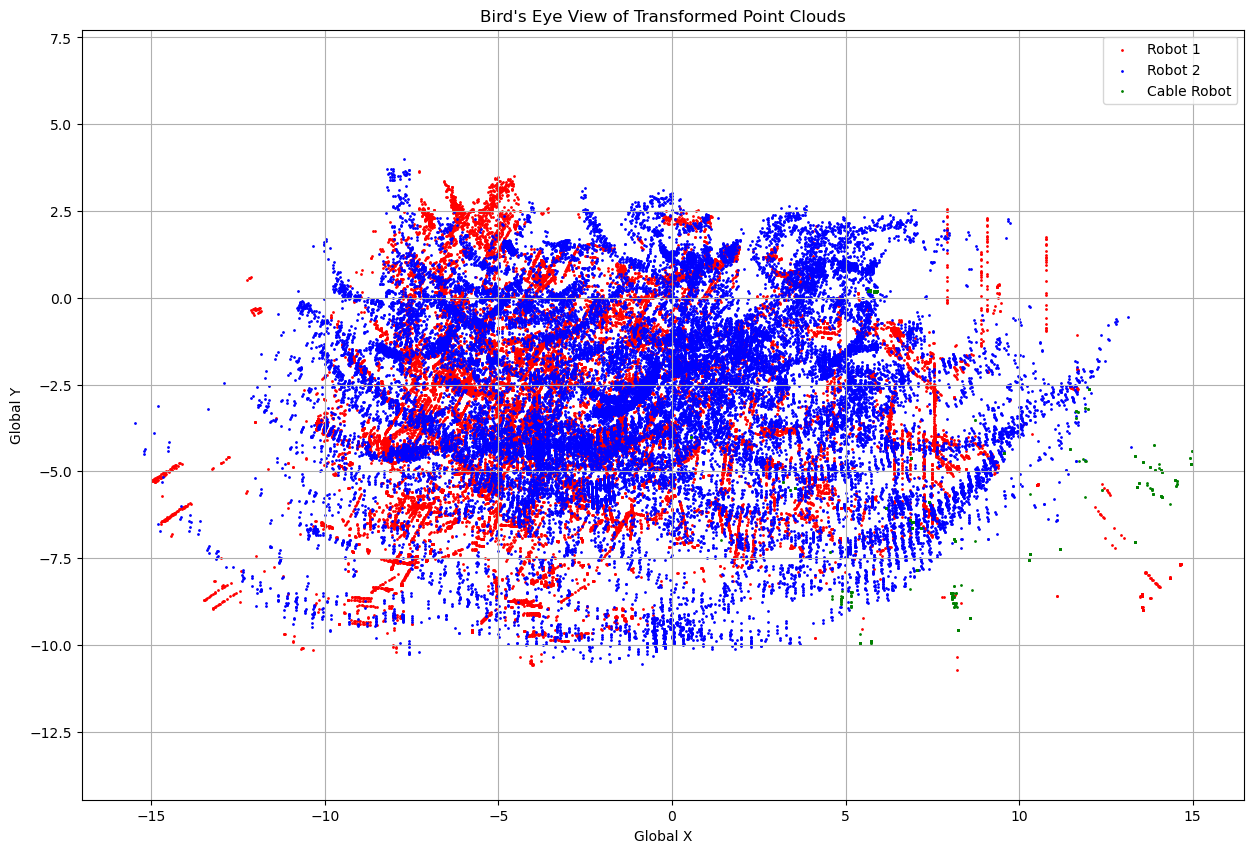

In [25]:

plt.figure(figsize=(15, 10))

# Plot transformed global points for each robot
colors = {'robot_1': 'red', 'robot_2': 'blue', 'cable_robot': 'green'}
for robot in robot_mappings.keys():
    global_x_col = f"{robot}_global_x"
    global_y_col = f"{robot}_global_y"
    all_x = np.hstack(df[global_x_col].values)
    all_y = np.hstack(df[global_y_col].values)
    plt.scatter(all_x, all_y, c=colors[robot], label=robot.replace('_', ' ').title(), s=1)

plt.xlabel('Global X')
plt.ylabel('Global Y')
plt.title("Bird's Eye View of Transformed Point Clouds")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

## Slider plot


In [24]:
import plotly.graph_objects as go

df['vicon_timestamp'] = pd.to_datetime(df['vicon_timestamp'])

# Sort dataframe by timestamp
df = df.sort_values(by='vicon_timestamp')

# Get unique timestamps
timestamps = df['vicon_timestamp'].unique()

# Define fixed scale for plotting
xmin = df[['robot_1_global_x', 'robot_2_global_x', 'cable_robot_global_x']].min().min()
xmax = df[['robot_1_global_x', 'robot_2_global_x', 'cable_robot_global_x']].max().max()
ymin = df[['robot_1_global_y', 'robot_2_global_y', 'cable_robot_global_y']].min().min()
ymax = df[['robot_1_global_y', 'robot_2_global_y', 'cable_robot_global_y']].max().max()

# Robot colors
colors = {'robot_1': 'red', 'robot_2': 'blue', 'cable_robot': 'green'}

# Create figure
fig = go.Figure()

# Create frames for animation
frames = []
for timestamp in timestamps:
    df_filtered = df[df['vicon_timestamp'] == timestamp]  # Filter data for current timestamp
    frame_data = []
    
    for robot, color in colors.items():
        global_x_col = f"{robot}_global_x"
        global_y_col = f"{robot}_global_y"

        # Extract all points
        all_x = np.hstack(df_filtered[global_x_col].values)
        all_y = np.hstack(df_filtered[global_y_col].values)

        frame_data.append(
            go.Scatter(x=all_x, y=all_y, mode='markers', marker=dict(color=color, size=2), hoverinfo="skip")
        )
    
    frames.append(go.Frame(data=frame_data, name=str(timestamp)))

# Initial plot (first timestamp)
df_initial = df[df['vicon_timestamp'] == timestamps[0]]
for robot, color in colors.items():
    global_x_col = f"{robot}_global_x"
    global_y_col = f"{robot}_global_y"
    
    all_x = np.hstack(df_initial[global_x_col].values)
    all_y = np.hstack(df_initial[global_y_col].values)

    fig.add_trace(go.Scatter(x=all_x, y=all_y, mode='markers', marker=dict(color=color, size=2), hoverinfo="skip"))

# Update layout for fixed scale and interactivity
fig.update_layout(
    width=1200, height=800, showlegend=False,
    xaxis=dict(showticklabels=False, showgrid=False, title="", range=[xmin, xmax]),
    yaxis=dict(showticklabels=False, showgrid=False, title="", range=[ymin, ymax]),
    updatemenus=[{
        "buttons": [
            {"args": [None, {"frame": {"duration": 1000, "redraw": True}, "mode": "immediate"}], "label": "Play", "method": "animate"},
            {"args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}], "label": "Pause", "method": "animate"}
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }],
    sliders=[{
        "active": 0,
        "currentvalue": {"prefix": "Timestamp: "},
        "pad": {"t": 50},
        "steps": [{"args": [[str(timestamp)], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                   "label": str(timestamp), "method": "animate"} for timestamp in timestamps]
    }]
)

# Assign frames to figure
fig.update(frames=frames)

# Show the plot
fig.show()


/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value encountered in reduce

/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value encountered in reduce

/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:45: RuntimeWarning:

invalid value encountered in reduce

/home/asfy/anaconda3/envs/robo_fuse/lib/python3.11/site-packages/numpy/core/_methods.py:41: RuntimeWarning:

invalid value e

### Read Radar Node Position ###

In [ ]:
import pandas as pd
import json
import numpy as np
import os
# Step 2: Read and decode Vicon data files

def read_vicon_radar_pos(file_paths):
    vicon_dataframes = []
    
    for file in file_paths:
        with open(file, 'r') as f:
            rows = []
            for line in f:
                line = line.strip()  # Remove whitespace or newline characters
                if line:  # Skip empty lines
                    try:
                        vicon_dict = eval(line)  # Evaluate the line into a dictionary
                        object_count = 1  # Initialize object counter
                        row_data = {}
                        for key, value in vicon_dict.items():
                            # Robust check to skip rows where all values are zero
                            if isinstance(value, dict) and all(v == 0 for v in value.values()):
                                continue  # Skip this entry
                            # Extract object name from key
                            object_name = key.split("/")[1]
                            # Rename keys with object_name prefix and handle multiple objects
                            renamed_value = {
                                f"{object_name}_{k}": v
                                for k, v in value.items()
                                if k not in ['frame_number', 'total_latency', 'quality']
                            }
                            # Add vicon_timestamp for the first object
                            if object_count == 1:
                                renamed_value['vicon_timestamp'] = renamed_value.pop(f"{object_name}_system_time") / 1e9
                            else:
                                renamed_value[f'object_name_{object_count}'] = object_name
                                renamed_value[f"object_name_{object_count}_timestamp"] = renamed_value.pop(
                                    f"{object_name}_system_time"
                                ) / 1e9
                            # Add object_name for the first object
                            if object_count == 1:
                                renamed_value['object_name_1'] = object_name
                            row_data.update(renamed_value)
                            object_count += 1
                        # Add row if it's not empty
                        if row_data:  # Ensure that the row contains valid data
                            rows.append(row_data)
                    except SyntaxError as e:
                        print(f"Error parsing line: {line}\n{e}")
            
            # Create a DataFrame for the parsed rows
            if rows:
                df = pd.DataFrame(rows)
                vicon_dataframes.append(df)
    
    # Combine all DataFrames into one
    vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()

    # Reorder columns: vicon_timestamp first, followed by object_name columns, then the rest
    if not vicon_df.empty:
        columns = sorted(
            [col for col in vicon_df.columns if 'vicon_timestamp' in col] +
            [col for col in vicon_df.columns if col.startswith('object_name')],
            key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0
        )
        remaining_columns = [col for col in vicon_df.columns if col not in columns]
        vicon_df = vicon_df[columns + remaining_columns]
    
    return vicon_df

radar_pos_vicon_files = [
    "measurements/vicon_data/radar_TI_positions_new_20250114_113456.txt"
]

radar_pos_vicon_df = read_vicon_radar_pos(radar_pos_vicon_files)
radar_pos_vicon_df



In [ ]:
import pandas as pd
import re

def compute_radar_averages(vicon_df):
    """
    Computes the average position and orientation for each radar (Radar 1, Radar 2, Radar 3).
    
    Args:
        vicon_df (pd.DataFrame): DataFrame containing Vicon radar position data.

    Returns:
        pd.DataFrame: A DataFrame with averaged position and orientation data per radar.
    """
    # Identify radar names (e.g., radar_TI_1, radar_TI_2, radar_TI_3)
    radar_objects = sorted(set(col.split("_")[2] for col in vicon_df.columns if col.startswith("radar_TI_")))

    # Define relevant columns for averaging
    relevant_columns = ['pos_x', 'pos_y', 'pos_z', 'yaw', 'rot_x', 'rot_y', 'rot_z']

    # Initialize a dictionary to store the averages
    radar_averages = {}

    for radar_id in radar_objects:
        radar_data = {}
        for col in relevant_columns:
            radar_col_name = f"radar_TI_{radar_id}_{col}"
            if radar_col_name in vicon_df.columns:
                radar_data[col] = vicon_df[radar_col_name].mean()  # Compute column mean

        radar_averages[f"Radar {radar_id}"] = radar_data  # Store averages under "Radar X"

    # Convert the dictionary to a DataFrame and transpose it for readability
    radar_averages_df = pd.DataFrame(radar_averages).T
    radar_averages_df.index.name = "Radar"

    return radar_averages_df

# Read the Vicon data
#vicon_df = read_vicon_data(vicon_files)

# Compute the average positions for radar objects
average_radar_positions_df = compute_radar_averages(radar_pos_vicon_df)

# Save the results to a CSV file
#average_radar_positions_df.to_csv("average_radar_positions.csv", index=False)

# Display results
print("Averaged Radar Positions DataFrame:")
print(average_radar_positions_df.head())


In [ ]:
#average_radar_positions_df.to_csv("average_radar_positions.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt

def plot_radar_positions(df, x_col="pos_x", y_col="pos_y"):
    """
    Plots a scatter plot of radar positions based on pos_x and pos_y.

    Args:
        df (pd.DataFrame): DataFrame containing radar positions.
        x_col (str): Column name for X coordinates (default: 'pos_x').
        y_col (str): Column name for Y coordinates (default: 'pos_y').
    """
    # Define boundary coordinates
    boundary_x = [-9.1, -9.1, 10.2, 10.2, -9.1]
    boundary_y = [-4.42, 5.5, 5.5, -4.42, -4.42]

    plt.figure(figsize=(8, 6))
    
    # Scatter plot of radar positions
    plt.scatter(df[x_col], df[y_col], color="blue", marker="o", label="Radar Positions")

    # Plot boundary box
    plt.plot(boundary_x, boundary_y, "r--", label="Boundary")

    # Labels and title
    plt.xlabel("X Coordinate (pos_x)")
    plt.ylabel("Y Coordinate (pos_y)")
    plt.title("Radar Positions Scatter Plot")
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

# Call the function to plot
plot_radar_positions(average_radar_positions_df)


### Map Tranformation of local 3D Point Clouds to Global Frame ###

In [ ]:
import pandas as pd
import numpy as np

# Load radar positions (Vicon-based global coordinates)
radar_positions_df = pd.read_csv("average_radar_positions.csv")

# Function to extract robot IDs from "object_name_" columns
def extract_robot_ids(df):
    """
    Extracts unique robot IDs from columns following the 'object_name_' pattern.
    """
    robot_cols = [col for col in df.columns if col.startswith("object_name_")]
    return {df[col].dropna().unique()[0]: col for col in robot_cols}  # Extract {ID: column_name} pairs

# Function to compute rotation matrix from yaw
def rotation_matrix(yaw):
    """
    Compute a 3x3 rotation matrix for given yaw (in degrees).
    """
    theta = np.radians(yaw)
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return R

# Function to transform local 3D point clouds to global coordinates
def transform_to_global(df, radar_positions):
    """
    Transforms radar's local 3D point clouds (x, y, z) into global coordinates.
    Adds new columns with transformed points.
    """
    # Extract robots
    robot_id_map = extract_robot_ids(df)  # {robot_name: column}

    # Loop through each radar node
    for radar_id in ["node_1", "node_2", "node_3"]:
        radar_data_cols = [f"{radar_id}_x", f"{radar_id}_y", f"{radar_id}_z"]
        
        if all(col in df.columns for col in radar_data_cols):
            # Get radar position and yaw
            radar_row = radar_positions[radar_positions["radar_id"] == radar_id]
            if radar_row.empty:
                continue
            
            radar_x, radar_y, radar_z = radar_row.iloc[0][["pos_x", "pos_y", "pos_z"]]
            radar_yaw = radar_row.iloc[0]["yaw"]

            # Compute rotation matrix
            R = rotation_matrix(radar_yaw)

            # Transform each robot's local 3D points
            for robot_id, robot_col in robot_id_map.items():
                local_coords = df[[f"{radar_id}_x", f"{radar_id}_y", f"{radar_id}_z"]].values.T
                global_coords = (R @ local_coords).T + np.array([radar_x, radar_y, radar_z])

                # Create new columns for global positions
                df[f"{radar_id}_x_global"] = global_coords[:, 0]
                df[f"{radar_id}_y_global"] = global_coords[:, 1]
                df[f"{radar_id}_z_global"] = global_coords[:, 2]

    return df

# Load radar measurement data
radar_df = pd.read_csv("output/sync_final_radar_vicon/horizontal_1_robot_1_mps.csv")

# Transform radar data to global coordinates
global_transformed_df = transform_to_global(radar_df, radar_positions_df)
global_transformed_df
# Save to CSV
#global_transformed_df.to_csv("output/sync_final_radar_vicon/global_transformed_radar.csv", index=False)

# Display first few rows
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Global Transformed Radar Data", dataframe=global_transformed_df)
